ex2data2.txt file contains some data concerning how certain brand new microchips have been graded on two different tests and whether or not they were accepted to be sold (data comes from Andrew Ng's Machine Learning course on Coursera). My goal is to determine which other microchips should be accepted based on how they have been graded on the two tests. In order to solve this classification problem I will implement regularised logistic regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from numbers import Number # for sigmoid(x) function

Data visualisation:

In [2]:
data = pd.read_csv('ex2data2.txt', header=None, names=['Test 1', 'Test 2', 'y']) # y is the decision if a chip was accepted to be sold
data.head()

,Test 1,Test 2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
m = len(data) # number of entries in the data set
m

118

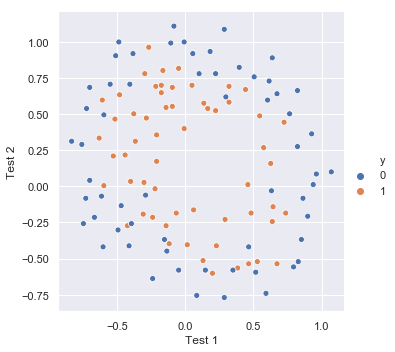

In [4]:
g = sns.relplot(x='Test 1', y='Test 2', hue='y', data=data)

Logistic regression hypothesis is defined as $h_\theta(x) = g(\theta^T x)$, where $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function.

In [5]:
def sigmoid(x):
    if isinstance(x, Number):
        return 1/(1+np.exp(-x))
    else:
        return np.divide(np.ones(x.shape), np.add(np.ones(x.shape), np.exp(np.negative(x))))

(-10, 10)

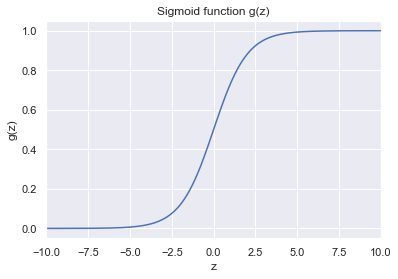

In [6]:
a = np.arange(-10,10, 0.01)
plt.plot(a, sigmoid(a))
plt.title('Sigmoid function g(z)')
plt.xlabel('z')
plt.ylabel('g(z)')
plt.xlim([-10, 10])

In [7]:
y = data['y'].values
X = data[['Test 1', 'Test 2']].values

To fit the decision boundery (and hypothesis function) to data better I will introduce more features for each data point. As in the course I will map the features into the polynomial terms of $x_1$ and $x_2$ up to the sixth power: $x = [1\ x_1\ x_2\ x_1^2\ x_1x_2\ x_2^2\ x_1^3\ ...\ x_1x_2^5\ x_2^6]^T$ (I will also add a 1 before all the features so it will be possible to compute $\theta_0 \cdot 1 + \theta_1 x_1 + ... \theta_n x_n$ as $\theta^T x$).

In [8]:
X = np.insert(X, 0, 1, axis=1)
X

array([[ 1.       ,  0.051267 ,  0.69956  ],
       [ 1.       , -0.092742 ,  0.68494  ],
       [ 1.       , -0.21371  ,  0.69225  ],
       [ 1.       , -0.375    ,  0.50219  ],
       [ 1.       , -0.51325  ,  0.46564  ],
       [ 1.       , -0.52477  ,  0.2098   ],
       [ 1.       , -0.39804  ,  0.034357 ],
       [ 1.       , -0.30588  , -0.19225  ],
       [ 1.       ,  0.016705 , -0.40424  ],
       [ 1.       ,  0.13191  , -0.51389  ],
       [ 1.       ,  0.38537  , -0.56506  ],
       [ 1.       ,  0.52938  , -0.5212   ],
       [ 1.       ,  0.63882  , -0.24342  ],
       [ 1.       ,  0.73675  , -0.18494  ],
       [ 1.       ,  0.54666  ,  0.48757  ],
       [ 1.       ,  0.322    ,  0.5826   ],
       [ 1.       ,  0.16647  ,  0.53874  ],
       [ 1.       , -0.046659 ,  0.81652  ],
       [ 1.       , -0.17339  ,  0.69956  ],
       [ 1.       , -0.47869  ,  0.63377  ],
       [ 1.       , -0.60541  ,  0.59722  ],
       [ 1.       , -0.62846  ,  0.33406  ],
       [ 1

In [9]:
degree = 6
new_features = np.zeros((len(X), (degree+1)*(degree+2)//2 - 3))
X1 = X[:, 1]
X2 = X[:, 2]
counter = 0
for i in range(2, degree+1):
    for j in range(i+1):
        new_features[:, counter] = np.multiply(np.power(X1, i-j), np.power(X2, j))
        counter += 1
X = np.concatenate((X, new_features), axis=1)

In [10]:
X

array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01, ...,
         6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
       [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01, ...,
         1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
       [ 1.00000000e+00, -2.13710000e-01,  6.92250000e-01, ...,
         1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
       ...,
       [ 1.00000000e+00, -4.84450000e-01,  9.99270000e-01, ...,
         2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
       [ 1.00000000e+00, -6.33640000e-03,  9.99270000e-01, ...,
         4.00328554e-05, -6.31330588e-03,  9.95627986e-01],
       [ 1.00000000e+00,  6.32650000e-01, -3.06120000e-02, ...,
         3.51474517e-07, -1.70067777e-08,  8.22905998e-10]])

In [11]:
X.shape

(118, 28)

Now my vectors of features are 28 dimensional. The decision boundary will be more complex and will appear to be non-linear on a 2 dimensional graph. Feature mapping will allow me to build a better fitted, more complex model but I have to be careful because my model may overfit the data set. That is why I will regularise parameters $\theta_j$ for j = 1 to n (I will not regularise $\theta_0$).

Regularised cost function for logistic regression is defined as: $J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$

In [12]:
def cost_function(theta, X, y, regularisation_parameter):
    m = len(X)
    h = sigmoid(X@theta)
    return 1/m * sum(np.subtract(np.multiply(np.negative(y), np.log(h)), np.multiply(np.subtract(np.ones(m), y), np.log(np.subtract(np.ones(m), h))))) + regularisation_parameter/2/m * sum(np.power(theta[1:], 2))

In [13]:
theta = np.zeros(28)
cost_function(theta, X, y, 1)

0.6931471805599461

By calculating partial derivatives $\frac{\partial J}{\partial \theta_j}$ I get gradient of $J(\theta)$. The gradient is: $\frac{\partial J}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$ for j = 0 and $\frac{\partial J}{\partial \theta_j} = (\frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m} \theta_j$ for j = 1 to n.

In [14]:
def gradient(theta, X, y, regularisation_parameter):
    gradient = np.zeros(len(theta))
    h = sigmoid(X@theta)
    gradient[0] = 1/m * sum(np.multiply(np.subtract(h, y), X[:, 0]))
    for j in range(1,len(theta)):
        gradient[j] = 1/m * sum(np.multiply(np.subtract(h, y), X[:, j])) + regularisation_parameter/m * theta[j]
    return gradient

In [15]:
theta = np.ones(28)
gradient(theta, X, y, 10)

array([0.34604507, 0.16135192, 0.19479576, 0.22686278, 0.09218568,
       0.24438558, 0.14339212, 0.10844171, 0.10231439, 0.18346846,
       0.17353003, 0.08725552, 0.11822776, 0.0858433 , 0.19994895,
       0.13522653, 0.09497527, 0.09356441, 0.09979784, 0.09140157,
       0.17485242, 0.14955442, 0.08678566, 0.09897686, 0.08531951,
       0.10190666, 0.08450198, 0.18228323])

Now I will use SciPy's minimize function to learn optimal parameters of hypothesis function. I will use BFGS algorithm.

In [16]:
from scipy.optimize import minimize

In [17]:
initial_theta = np.zeros(28)
regularisation_parameter = 1
theta = minimize(lambda x: cost_function(x, X, y, regularisation_parameter), initial_theta, method='BFGS', jac=lambda x: gradient(x, X, y, regularisation_parameter), options={'disp' : True})

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


In [18]:
theta = theta.x
theta

array([ 1.27268739,  0.62557016,  1.1809665 , -2.01919822, -0.91761468,
       -1.43194199,  0.12375921, -0.36513086, -0.35703388, -0.17485805,
       -1.45843772, -0.05129676, -0.61603963, -0.2746414 , -1.19282569,
       -0.24270336, -0.20570022, -0.04499768, -0.27782709, -0.29525851,
       -0.45613294, -1.04377851,  0.02762813, -0.29265642,  0.01543393,
       -0.32759318, -0.14389199, -0.92460119])

Now I am able to plot the decision boundary.

Text(0.5, 1.0, 'lambda = 1')

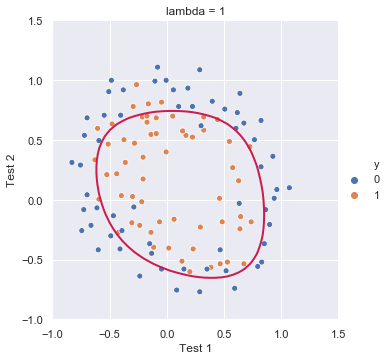

In [19]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

def helper_function(z, u, v, theta):
    for i in range(len(u)):
        for j in range(len(v)):
            vector = np.zeros(28)
            counter = 0
            for k in range(6+1):
                for l in range(k+1):
                    vector[counter] = u[i]**(k-l) * v[j]**l
                    counter += 1
            z[i,j] = vector.dot(theta)
    return z
z = helper_function(z, u, v, theta)
U, V = np.meshgrid(u,v)
sns.relplot(x='Test 1', y='Test 2', hue='y', data=data)
plt.contour(U, V, z, 0, linewidths=2)
plt.title('lambda = 1')

Now I can see how regularisation parameter $\lambda$ influences the model.

Optimization terminated successfully.
         Current function value: 0.224569
         Iterations: 546
         Function evaluations: 547
         Gradient evaluations: 547


Text(0.5, 1.0, 'lambda = 0 (no regularisation - overfitting example)')

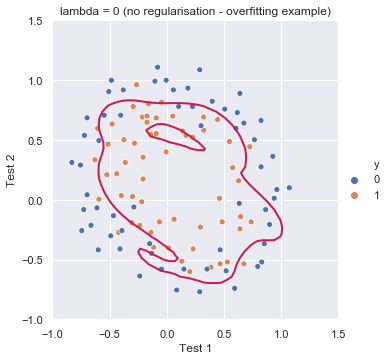

In [20]:
regularisation_parameter = 0
theta = minimize(lambda x: cost_function(x, X, y, regularisation_parameter), initial_theta, method='BFGS', jac=lambda x: gradient(x, X, y, regularisation_parameter), options={'disp' : True})
theta = theta.x
z = helper_function(z, u, v, theta)
sns.relplot(x='Test 1', y='Test 2', hue='y', data=data)
plt.contour(U, V, z, 0, linewidths=2)
plt.title('lambda = 0 (no regularisation - overfitting example)')

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


Text(0.5, 1.0, 'lambda = 100 (underfitting example)')

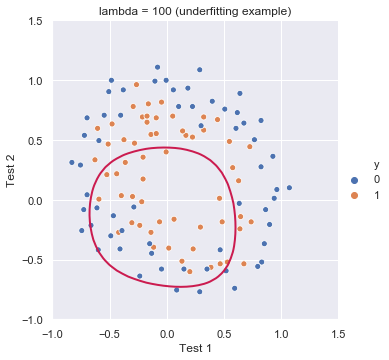

In [21]:
regularisation_parameter = 100
theta = minimize(lambda x: cost_function(x, X, y, regularisation_parameter), initial_theta, method='BFGS', jac=lambda x: gradient(x, X, y, regularisation_parameter), options={'disp' : True})
theta = theta.x
z = helper_function(z, u, v, theta)
sns.relplot(x='Test 1', y='Test 2', hue='y', data=data)
plt.contour(U, V, z, 0, linewidths=2)
plt.title('lambda = 100 (underfitting example)')

In [22]:
regularisation_parameter = 1
theta = minimize(lambda x: cost_function(x, X, y, regularisation_parameter), initial_theta, method='BFGS', jac=lambda x: gradient(x, X, y, regularisation_parameter), options={'disp' : True})
theta = theta.x

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


Now I will predict whether the chips from my training data sets should be accepted or rejected for sale and see how accurate my model is.

In [23]:
threshold = 0.5
prediction = sigmoid(X.dot(theta))
prediction = np.array([1 if prediction[i] >= threshold else 0 for i in range(len(prediction))])
accuracy = (prediction == y).mean() * 100
accuracy

83.05084745762711

My model qualified correctly 83% of the examples.